# Batch processing of LoC monolayer images

Segmentation, tracking over Z, extracting single-cell pixel intensity distributions

In [3]:
import dask.array as da
import napari
import btrack
from tqdm.auto import tqdm
from skimage.io import imshow,  imsave, imread
import skimage as ski
import itertools
import json, os, glob, shutil
import numpy as np
import matplotlib.pyplot as plt
from cellpose import core, utils, io, models, metrics
from pathlib import Path
import pandas as pd
plt.rcParams["figure.figsize"] = (15,7)
import seaborn as sns
sns.set(font='Nimbus Sans', style = 'white')

In [4]:
import enum
@enum.unique
class Channels_1(enum.Enum): ### this is unique to the above acquisition (20x_21-12-031B_A12456_Multichannel Z-Stack_20220811_113.vsi - 005 CF405, CF488, CF561, CF638.tif)
    DAPI = 0
    NKX21 = 1
    PDPN = 2
    ZO1 = 3

In [5]:
class Channels_2(enum.Enum): ### this is unique to the above acquisition (20x_21-12-031B_A12456_Multichannel Z-Stack_20220811_113.vsi - 005 CF405, CF488, CF561, CF638.tif)
    DAPI = 0
    SPC = 1
    PDPN = 2
    ZO1 = 3

In [6]:
!nvcc --version
!nvidia-smi
use_GPU = core.use_gpu()
yn = ['NO', 'YES']
print(f'>>> GPU activated? {yn[use_GPU]}')
# define model_type='cyto' or model_type='nuclei'
model = models.Cellpose(gpu=use_GPU, model_type='cyto')
# define CHANNELS to run segementation on
channels = [0,0]

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243
Mon Jun 19 11:21:13 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.105.01   Driver Version: 515.105.01   CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A6000    On   | 00000000:65:00.0  On |                  Off |
| 30%   40C    P8    34W / 300W |   2297MiB / 49140MiB |      8%      Default |
|                               |                      |                  N/A |
+

In [7]:
props = ('axis_major_length', 
         'axis_minor_length', 
         'eccentricity', 
         'area', 
         'mean_intensity', 
         #'intensity_image', 
         'orientation')


# Loading images

In [11]:
image_fn

'/mnt/DATA/sandbox/lung_on_chip/monolayer/21-12-031B/122/20x_21-12-031B_A12456_Multichannel Z-Stack_20220811_122.vsi - 014 CF405, CF488, CF561, CF638.tif'

In [12]:
image_fns

['/mnt/DATA/sandbox/lung_on_chip/monolayer/21-12-031B/122/20x_21-12-031B_A12456_Multichannel Z-Stack_20220811_122.vsi - 014 CF405, CF488, CF561, CF638.tif',
 '/mnt/DATA/sandbox/lung_on_chip/monolayer/21-12-031B/113/masks.tif',
 '/mnt/DATA/sandbox/lung_on_chip/monolayer/21-12-031B/113/20x_21-12-031B_A12456_Multichannel Z-Stack_20220811_113.vsi - 005 CF405, CF488, CF561, CF638.tif',
 '/mnt/DATA/sandbox/lung_on_chip/monolayer/21-12-031B/113/cropped_[25:45]_masks.tif',
 '/mnt/DATA/sandbox/lung_on_chip/monolayer/21-12-028A/245/20x_21-12-028A_A23456_Multichannel Z-Stack_20220818_245.vsi - 014 CF405, CF488, CF561, CF638.tif',
 '/mnt/DATA/sandbox/lung_on_chip/monolayer/21-12-028A/236/20x_21-12-028A_A23456_Multichannel Z-Stack_20220818_236.vsi - 005 CF405, CF488, CF561, CF638.tif']

In [359]:
image.shape

(81, 2304, 2304, 4)

In [361]:
masks

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)

In [16]:
image_fns = glob.glob('/mnt/DATA/sandbox/lung_on_chip/monolayer/*/*/*CF638.tif')
for image_fn in tqdm(image_fns):
    ### load image 
    print(f'Loading image {os.path.basename(image_fn)}')
    image = imread(image_fn)
    ### define channels
    ch0 = image[...,0]
    ch1 = image[...,1]
    ch2 = image[...,2]
    ch3 = image[...,3]
    ### define empty mask stack 
    mask_stack = []
    print(f'Segmenting image {os.path.basename(image_fn)}')
    ### iterate over frames
    for frame in tqdm(ch3, total = len(ch3)):
        ### run segmentation
        masks, flows, styles, diams = model.eval(frame, diameter=None, flow_threshold=None, channels=channels)
        ### append to mask stack
        mask_stack.append(masks)
    ### stack masks together
    mask_stack = np.stack(mask_stack, axis = 0)    ### create mask fn
    mask_fn = image_fn.split('Multichannel')[0]+('mask_stack.tif')
    imsave(mask_fn, mask_stack)
    ### extract objects for tracking
    objects = btrack.utils.segmentation_to_objects(
                                                    mask_stack, 
                                                    image,
                                                    properties = props, 
                                                    use_weighted_centroid=False)
    print(f'Tracking image {os.path.basename(image_fn)}')
    # initialise a tracker session using a context manager
    with btrack.BayesianTracker() as tracker:
      # configure the tracker using a config file
      tracker.configure('/home/dayn/analysis/BayesianTracker/models/particle_config.json')
      # append the objects to be tracked
      tracker.append(objects)
      # set the volume (Z axis volume limits default to [-1e5, 1e5] for 2D data)
      tracker.volume = ((0, 2304), (0, 2304))
      # track them (in interactive mode)
      tracker.track_interactive(step_size=100)
      # generate hypotheses and run the global optimizer
      tracker.optimize()
      # get the tracks as a python list
      tracks = tracker.tracks
      # filter tracks
      tracks = [track for track in tracks if len(track) >= 3]
      ### export the tracks
      tracks_fn = image_fn.split('Multichannel')[0]+('tracks.h5')
      tracker.export(tracks_fn, obj_type = "obj_type_1")
    
    print(f'Extracting measurements of image {os.path.basename(image_fn)}')
    ### define channels of this experiment
    if '113.vsi' in image_fn or '236.vsi' in image_fn:
        channels = Channels_2
    if '122.vsi' in image_fn or '245.vsi' in image_fn:
        channels = Channels_1
    ### define parameters to plot in table
    cols = ['Cell ID', f'Max. int. {channels(0).name}', f'Max. int. {channels(1).name}', f'Max. int. {channels(2).name}', f'Max. int. {channels(3).name}', 'Average X', 'Average Y']
    ### extract some intial measurements
    df = pd.DataFrame([(track.ID, np.nanmax(track['mean_intensity-0']),np.nanmax(track['mean_intensity-1']),np.nanmax(track['mean_intensity-2']),np.nanmax(track['mean_intensity-3']), np.mean(track.x), np.mean(track.y)) for track in tracks], columns= cols)
    ### results path 
    output_path = os.path.split(image_fn.replace('/mnt/DATA/sandbox/','/home/dayn/data/'))[0]
    Path(output_path).mkdir(parents=True, exist_ok=True)
    output_fn = os.path.split(output_path)[-1]+'_single_cell_props.csv'
    output_path = os.path.join(output_path, output_fn)
    ### save dataframe
    df.to_csv(output_path)

  0%|          | 0/4 [00:00<?, ?it/s]

Loading image 20x_21-12-031B_A12456_Multichannel Z-Stack_20220811_122.vsi - 014 CF405, CF488, CF561, CF638.tif
Segmenting image 20x_21-12-031B_A12456_Multichannel Z-Stack_20220811_122.vsi - 014 CF405, CF488, CF561, CF638.tif


  0%|          | 0/81 [00:00<?, ?it/s]

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
[INFO][2022/11/04 12:22:47 PM] Localizing objects from segmentation...
[INFO][2022/11/04 12:22:47 PM] Found intensity_image data
[INFO][2022/11/04 12:23:18 PM] Objects are of type: <class 'dict'>
[INFO][2022/11/04 12:23:19 PM] ...Found 80134 objects in 81 frames.
[INFO][2022/11/04 12:23:19 PM] Loaded btrack: /home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/btrack/libs/libtracker.so
[INFO][2022/11/04 12:23:19 PM] btrack (v0.4.5) library imported
[INFO][2022/11/04 12:23:19 PM] Starting BayesianTracker session
[INFO][2022/11/04 12:23:19 PM] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/particle_

Tracking image 20x_21-12-031B_A12456_Multichannel Z-Stack_20220811_122.vsi - 014 CF405, CF488, CF561, CF638.tif


[INFO][2022/11/04 12:37:14 PM]  - Timing (Bayesian updates: 13.30ms, Linking: 0.98ms)
[INFO][2022/11/04 12:37:14 PM]  - Probabilities (Link: 0.60882, Lost: 0.72535)
[INFO][2022/11/04 12:37:14 PM] SUCCESS.
[INFO][2022/11/04 12:37:14 PM]  - Found 13956 tracks in 81 frames (in 0.0s)
[INFO][2022/11/04 12:37:14 PM]  - Inserted 13342 dummy objects to fill tracking gaps
[INFO][2022/11/04 12:37:14 PM] Loading hypothesis model: particle_hypothesis
[INFO][2022/11/04 12:37:14 PM] Calculating hypotheses (relax: True)...
[INFO][2022/11/04 12:37:14 PM] Setting up constraints matrix for global optimisation...
[INFO][2022/11/04 12:37:14 PM] Using GLPK options: {'tm_lim': 60000}...
[INFO][2022/11/04 12:37:16 PM] Optimizing...
[INFO][2022/11/04 12:37:29 PM] Optimization complete. (Solution: optimal)
[INFO][2022/11/04 12:37:29 PM]  - Fates.FALSE_POSITIVE: 4865 (of 13956)
[INFO][2022/11/04 12:37:29 PM]  - Fates.LINK: 1847 (of 7884)
[INFO][2022/11/04 12:37:29 PM]  - Fates.INITIALIZE_BORDER: 1403 (of 2578)


GLPK Integer Optimizer 5.0
55824 rows, 49752 columns, 71592 non-zeros
49752 integer variables, all of which are binary
Preprocessing...
27912 rows, 49752 columns, 71592 non-zeros
49752 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 27912
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
27912 rows, 49752 columns, 71592 non-zeros
*     0: obj =   1.580634325e+05 inf =   0.000e+00 (13692)
Perturbing LP to avoid stalling [1068]...
*  4684: obj =   1.143133895e+05 inf =   0.000e+00 (7868)
*  8333: obj =   1.030676868e+05 inf =   0.000e+00 (3158) 3
Removing LP perturbation [11262]...
* 11262: obj =   9.849952411e+04 inf =   0.000e+00 (0) 3
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+ 11262: mip =     not found yet >=              -inf        (1; 0)
+ 11262: >>>>>   9.849952

[INFO][2022/11/04 12:37:30 PM] Opening HDF file: /mnt/DATA/sandbox/lung_on_chip/monolayer/21-12-031B/122/20x_21-12-031B_A12456_tracks.h5...
[INFO][2022/11/04 12:37:30 PM] Writing objects/obj_type_1
[INFO][2022/11/04 12:37:30 PM] Writing labels/obj_type_1
[INFO][2022/11/04 12:37:30 PM] Loading objects/obj_type_1 (80134, 5) (80134 filtered: None)
[INFO][2022/11/04 12:37:31 PM] Writing properties/obj_type_1/axis_major_length (80134,)
[INFO][2022/11/04 12:37:31 PM] Writing properties/obj_type_1/axis_minor_length (80134,)
[INFO][2022/11/04 12:37:31 PM] Writing properties/obj_type_1/eccentricity (80134,)
[INFO][2022/11/04 12:37:31 PM] Writing properties/obj_type_1/area (80134,)
[INFO][2022/11/04 12:37:31 PM] Writing properties/obj_type_1/mean_intensity-0 (80134,)
[INFO][2022/11/04 12:37:31 PM] Writing properties/obj_type_1/mean_intensity-1 (80134,)
[INFO][2022/11/04 12:37:31 PM] Writing properties/obj_type_1/mean_intensity-2 (80134,)
[INFO][2022/11/04 12:37:31 PM] Writing properties/obj_type

Extracting measurements of image 20x_21-12-031B_A12456_Multichannel Z-Stack_20220811_122.vsi - 014 CF405, CF488, CF561, CF638.tif
Loading image 20x_21-12-031B_A12456_Multichannel Z-Stack_20220811_113.vsi - 005 CF405, CF488, CF561, CF638.tif
Segmenting image 20x_21-12-031B_A12456_Multichannel Z-Stack_20220811_113.vsi - 005 CF405, CF488, CF561, CF638.tif


  0%|          | 0/81 [00:00<?, ?it/s]

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
[INFO][2022/11/04 12:49:21 PM] Localizing objects from segmentation...
[INFO][2022/11/04 12:49:21 PM] Found intensity_image data
[INFO][2022/11/04 12:49:49 PM] Objects are of type: <class 'dict'>
[INFO][2022/11/04 12:49:49 PM] ...Found 65159 objects in 81 frames.
[INFO][2022/11/04 12:49:49 PM] Loaded btrack: /home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/btrack/libs/libtracker.so
[INFO][2022/11/04 12:49:49 PM] btrack (v0.4.5) library imported
[INFO][2022/11/04 12:49:49 PM] Starting BayesianTracker session
[INFO][2022/11/04 12:49:49 PM] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/particle_

Tracking image 20x_21-12-031B_A12456_Multichannel Z-Stack_20220811_113.vsi - 005 CF405, CF488, CF561, CF638.tif


[INFO][2022/11/04 12:59:33 PM]  - Timing (Bayesian updates: 17.73ms, Linking: 1.18ms)
[INFO][2022/11/04 12:59:33 PM]  - Probabilities (Link: 0.45244, Lost: 1.00000)
[INFO][2022/11/04 12:59:33 PM] SUCCESS.
[INFO][2022/11/04 12:59:33 PM]  - Found 13724 tracks in 81 frames (in 0.0s)
[INFO][2022/11/04 12:59:33 PM]  - Inserted 11244 dummy objects to fill tracking gaps
[INFO][2022/11/04 12:59:33 PM] Loading hypothesis model: particle_hypothesis
[INFO][2022/11/04 12:59:33 PM] Calculating hypotheses (relax: True)...
[INFO][2022/11/04 12:59:33 PM] Setting up constraints matrix for global optimisation...
[INFO][2022/11/04 12:59:33 PM] Using GLPK options: {'tm_lim': 60000}...
[INFO][2022/11/04 12:59:34 PM] Optimizing...
[INFO][2022/11/04 12:59:50 PM] Optimization complete. (Solution: optimal)
[INFO][2022/11/04 12:59:50 PM]  - Fates.FALSE_POSITIVE: 5484 (of 13724)
[INFO][2022/11/04 12:59:50 PM]  - Fates.LINK: 1630 (of 8138)
[INFO][2022/11/04 12:59:50 PM]  - Fates.INITIALIZE_BORDER: 1442 (of 2768)


GLPK Integer Optimizer 5.0
54896 rows, 49310 columns, 71172 non-zeros
49310 integer variables, all of which are binary
Preprocessing...
27448 rows, 49310 columns, 71172 non-zeros
49310 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 27448
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
27448 rows, 49310 columns, 71172 non-zeros
*     0: obj =   1.532712333e+05 inf =   0.000e+00 (14357)
Perturbing LP to avoid stalling [896]...
*  3874: obj =   1.169460257e+05 inf =   0.000e+00 (9338)
*  7087: obj =   1.010477012e+05 inf =   0.000e+00 (5013) 2
* 11470: obj =   8.998907157e+04 inf =   0.000e+00 (414) 3
Removing LP perturbation [11886]...
* 11886: obj =   8.993574881e+04 inf =   0.000e+00 (0) 1
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+ 11886: mip =     not found yet >=

[INFO][2022/11/04 12:59:51 PM] Opening HDF file: /mnt/DATA/sandbox/lung_on_chip/monolayer/21-12-031B/113/20x_21-12-031B_A12456_tracks.h5...
[INFO][2022/11/04 12:59:51 PM] Writing objects/obj_type_1
[INFO][2022/11/04 12:59:51 PM] Writing labels/obj_type_1
[INFO][2022/11/04 12:59:51 PM] Loading objects/obj_type_1 (65159, 5) (65159 filtered: None)
[INFO][2022/11/04 12:59:52 PM] Writing properties/obj_type_1/axis_major_length (65159,)
[INFO][2022/11/04 12:59:52 PM] Writing properties/obj_type_1/axis_minor_length (65159,)
[INFO][2022/11/04 12:59:52 PM] Writing properties/obj_type_1/eccentricity (65159,)
[INFO][2022/11/04 12:59:52 PM] Writing properties/obj_type_1/area (65159,)
[INFO][2022/11/04 12:59:52 PM] Writing properties/obj_type_1/mean_intensity-0 (65159,)
[INFO][2022/11/04 12:59:52 PM] Writing properties/obj_type_1/mean_intensity-1 (65159,)
[INFO][2022/11/04 12:59:52 PM] Writing properties/obj_type_1/mean_intensity-2 (65159,)
[INFO][2022/11/04 12:59:52 PM] Writing properties/obj_type

Extracting measurements of image 20x_21-12-031B_A12456_Multichannel Z-Stack_20220811_113.vsi - 005 CF405, CF488, CF561, CF638.tif
Loading image 20x_21-12-028A_A23456_Multichannel Z-Stack_20220818_245.vsi - 014 CF405, CF488, CF561, CF638.tif
Segmenting image 20x_21-12-028A_A23456_Multichannel Z-Stack_20220818_245.vsi - 014 CF405, CF488, CF561, CF638.tif


  0%|          | 0/81 [00:00<?, ?it/s]

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
[INFO][2022/11/04 01:12:16 PM] Localizing objects from segmentation...
[INFO][2022/11/04 01:12:16 PM] Found intensity_image data
[INFO][2022/11/04 01:12:45 PM] Objects are of type: <class 'dict'>
[INFO][2022/11/04 01:12:46 PM] ...Found 75881 objects in 80 frames.
[INFO][2022/11/04 01:12:46 PM] Loaded btrack: /home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/btrack/libs/libtracker.so
[INFO][2022/11/04 01:12:46 PM] btrack (v0.4.5) library imported
[INFO][2022/11/04 01:12:46 PM] Starting BayesianTracker session
[INFO][2022/11/04 01:12:46 PM] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/particle_

Tracking image 20x_21-12-028A_A23456_Multichannel Z-Stack_20220818_245.vsi - 014 CF405, CF488, CF561, CF638.tif


[INFO][2022/11/04 01:33:21 PM]  - Timing (Bayesian updates: 0.12ms, Linking: 0.46ms)
[INFO][2022/11/04 01:33:21 PM]  - Probabilities (Link: 0.99103, Lost: 1.00000)
[INFO][2022/11/04 01:33:21 PM] SUCCESS.
[INFO][2022/11/04 01:33:21 PM]  - Found 13398 tracks in 80 frames (in 0.0s)
[INFO][2022/11/04 01:33:21 PM]  - Inserted 11887 dummy objects to fill tracking gaps
[INFO][2022/11/04 01:33:21 PM] Loading hypothesis model: particle_hypothesis
[INFO][2022/11/04 01:33:21 PM] Calculating hypotheses (relax: True)...
[INFO][2022/11/04 01:33:21 PM] Setting up constraints matrix for global optimisation...
[INFO][2022/11/04 01:33:21 PM] Using GLPK options: {'tm_lim': 60000}...
[INFO][2022/11/04 01:33:23 PM] Optimizing...
[INFO][2022/11/04 01:33:34 PM] Optimization complete. (Solution: optimal)
[INFO][2022/11/04 01:33:34 PM]  - Fates.FALSE_POSITIVE: 4094 (of 13398)
[INFO][2022/11/04 01:33:34 PM]  - Fates.LINK: 1525 (of 7169)
[INFO][2022/11/04 01:33:34 PM]  - Fates.INITIALIZE_BORDER: 1519 (of 2736)
[

GLPK Integer Optimizer 5.0
53592 rows, 47363 columns, 67930 non-zeros
47363 integer variables, all of which are binary
Preprocessing...
26796 rows, 47363 columns, 67930 non-zeros
47363 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 26796
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
26796 rows, 47363 columns, 67930 non-zeros
*     0: obj =   1.530718335e+05 inf =   0.000e+00 (12119)
Perturbing LP to avoid stalling [962]...
*  4531: obj =   1.137432201e+05 inf =   0.000e+00 (6024)
*  8669: obj =   1.039900209e+05 inf =   0.000e+00 (895) 3
Removing LP perturbation [9565]...
*  9565: obj =   1.036403262e+05 inf =   0.000e+00 (0) 2
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  9565: mip =     not found yet >=              -inf        (1; 0)
+  9565: >>>>>   1.036403262

[INFO][2022/11/04 01:33:35 PM] Opening HDF file: /mnt/DATA/sandbox/lung_on_chip/monolayer/21-12-028A/245/20x_21-12-028A_A23456_tracks.h5...
[INFO][2022/11/04 01:33:35 PM] Writing objects/obj_type_1
[INFO][2022/11/04 01:33:35 PM] Writing labels/obj_type_1
[INFO][2022/11/04 01:33:35 PM] Loading objects/obj_type_1 (75881, 5) (75881 filtered: None)
[INFO][2022/11/04 01:33:36 PM] Writing properties/obj_type_1/axis_major_length (75881,)
[INFO][2022/11/04 01:33:36 PM] Writing properties/obj_type_1/axis_minor_length (75881,)
[INFO][2022/11/04 01:33:36 PM] Writing properties/obj_type_1/eccentricity (75881,)
[INFO][2022/11/04 01:33:36 PM] Writing properties/obj_type_1/area (75881,)
[INFO][2022/11/04 01:33:36 PM] Writing properties/obj_type_1/mean_intensity-0 (75881,)
[INFO][2022/11/04 01:33:36 PM] Writing properties/obj_type_1/mean_intensity-1 (75881,)
[INFO][2022/11/04 01:33:36 PM] Writing properties/obj_type_1/mean_intensity-2 (75881,)
[INFO][2022/11/04 01:33:36 PM] Writing properties/obj_type

Extracting measurements of image 20x_21-12-028A_A23456_Multichannel Z-Stack_20220818_245.vsi - 014 CF405, CF488, CF561, CF638.tif
Loading image 20x_21-12-028A_A23456_Multichannel Z-Stack_20220818_236.vsi - 005 CF405, CF488, CF561, CF638.tif
Segmenting image 20x_21-12-028A_A23456_Multichannel Z-Stack_20220818_236.vsi - 005 CF405, CF488, CF561, CF638.tif


  0%|          | 0/81 [00:00<?, ?it/s]

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
[INFO][2022/11/04 01:45:20 PM] Localizing objects from segmentation...
[INFO][2022/11/04 01:45:20 PM] Found intensity_image data
[INFO][2022/11/04 01:45:50 PM] Objects are of type: <class 'dict'>
[INFO][2022/11/04 01:45:51 PM] ...Found 71886 objects in 79 frames.
[INFO][2022/11/04 01:45:51 PM] Loaded btrack: /home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/btrack/libs/libtracker.so
[INFO][2022/11/04 01:45:51 PM] btrack (v0.4.5) library imported
[INFO][2022/11/04 01:45:51 PM] Starting BayesianTracker session
[INFO][2022/11/04 01:45:51 PM] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/particle_

Tracking image 20x_21-12-028A_A23456_Multichannel Z-Stack_20220818_236.vsi - 005 CF405, CF488, CF561, CF638.tif


[INFO][2022/11/04 01:58:04 PM]  - Timing (Bayesian updates: 19.56ms, Linking: 1.07ms)
[INFO][2022/11/04 01:58:04 PM]  - Probabilities (Link: 0.38049, Lost: 1.00000)
[INFO][2022/11/04 01:58:04 PM] SUCCESS.
[INFO][2022/11/04 01:58:04 PM]  - Found 16185 tracks in 79 frames (in 0.0s)
[INFO][2022/11/04 01:58:05 PM]  - Inserted 18580 dummy objects to fill tracking gaps
[INFO][2022/11/04 01:58:05 PM] Loading hypothesis model: particle_hypothesis
[INFO][2022/11/04 01:58:05 PM] Calculating hypotheses (relax: True)...
[INFO][2022/11/04 01:58:05 PM] Setting up constraints matrix for global optimisation...
[INFO][2022/11/04 01:58:05 PM] Using GLPK options: {'tm_lim': 60000}...
[INFO][2022/11/04 01:58:07 PM] Optimizing...
[INFO][2022/11/04 01:58:30 PM] Optimization complete. (Solution: optimal)
[INFO][2022/11/04 01:58:30 PM]  - Fates.FALSE_POSITIVE: 7234 (of 16185)
[INFO][2022/11/04 01:58:30 PM]  - Fates.LINK: 1904 (of 11737)
[INFO][2022/11/04 01:58:30 PM]  - Fates.INITIALIZE_BORDER: 1286 (of 2409)

GLPK Integer Optimizer 5.0
64740 rows, 60292 columns, 88214 non-zeros
60292 integer variables, all of which are binary
Preprocessing...
32370 rows, 60292 columns, 88214 non-zeros
60292 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 32370
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
32370 rows, 60292 columns, 88214 non-zeros
*     0: obj =   1.905532028e+05 inf =   0.000e+00 (20090)
Perturbing LP to avoid stalling [923]...
*  3913: obj =   1.559165527e+05 inf =   0.000e+00 (13878)
*  7867: obj =   1.264944156e+05 inf =   0.000e+00 (9041) 2
* 10604: obj =   1.216299554e+05 inf =   0.000e+00 (5100) 3
* 14216: obj =   1.092708309e+05 inf =   0.000e+00 (1939) 4
Removing LP perturbation [16144]...
* 16144: obj =   1.077952238e+05 inf =   0.000e+00 (0) 3
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step

[INFO][2022/11/04 01:58:31 PM] Opening HDF file: /mnt/DATA/sandbox/lung_on_chip/monolayer/21-12-028A/236/20x_21-12-028A_A23456_tracks.h5...
[INFO][2022/11/04 01:58:31 PM] Writing objects/obj_type_1
[INFO][2022/11/04 01:58:31 PM] Writing labels/obj_type_1
[INFO][2022/11/04 01:58:31 PM] Loading objects/obj_type_1 (71886, 5) (71886 filtered: None)
[INFO][2022/11/04 01:58:32 PM] Writing properties/obj_type_1/axis_major_length (71886,)
[INFO][2022/11/04 01:58:32 PM] Writing properties/obj_type_1/axis_minor_length (71886,)
[INFO][2022/11/04 01:58:32 PM] Writing properties/obj_type_1/eccentricity (71886,)
[INFO][2022/11/04 01:58:32 PM] Writing properties/obj_type_1/area (71886,)
[INFO][2022/11/04 01:58:32 PM] Writing properties/obj_type_1/mean_intensity-0 (71886,)
[INFO][2022/11/04 01:58:32 PM] Writing properties/obj_type_1/mean_intensity-1 (71886,)
[INFO][2022/11/04 01:58:32 PM] Writing properties/obj_type_1/mean_intensity-2 (71886,)
[INFO][2022/11/04 01:58:32 PM] Writing properties/obj_type

Extracting measurements of image 20x_21-12-028A_A23456_Multichannel Z-Stack_20220818_236.vsi - 005 CF405, CF488, CF561, CF638.tif


# Filter tracks according to cell size and track length (z thickness)

In [11]:
track_fns = glob.glob('/mnt/DATA/lung_on_chip/monolayer/*/*/*.h5')

In [12]:
track_fns

['/mnt/DATA/lung_on_chip/monolayer/21-12-031B/122/20x_21-12-031B_A12456_tracks.h5',
 '/mnt/DATA/lung_on_chip/monolayer/21-12-031B/113/20x_21-12-031B_A12456_tracks.h5',
 '/mnt/DATA/lung_on_chip/monolayer/21-12-028A/245/20x_21-12-028A_A23456_tracks.h5',
 '/mnt/DATA/lung_on_chip/monolayer/21-12-028A/236/20x_21-12-028A_A23456_tracks.h5']

In [187]:
for track_fn in tqdm(track_fns):
    with btrack.dataio.HDF5FileHandler(track_fn, "r", obj_type="obj_type_1") as hdf:
        tracks = hdf.tracks
        tracks = [track for track in tracks if len(track) > 7]
    print(f'Extracting measurements of image {os.path.basename(track_fn)}')
    ### define channels of this experiment
    if '/113/' in track_fn or '/236/' in track_fn:
        channels = Channels_1
    if '/122/' in track_fn or '/245/' in track_fn:
        channels = Channels_2
    ### define parameters to plot in table
    cols = ['Cell ID', f'Max. int. {channels(0).name}', f'Max. int. {channels(1).name}', f'Max. int. {channels(2).name}', f'Max. int. {channels(3).name}', 'Average X', 'Average Y', 'Mean Area', 'Max. Area', 'Min. Area']
    ### extract some intial measurements
    measurements = [(track.ID, 
                     np.nanmax(track['mean_intensity-0']),
                     np.nanmax(track['mean_intensity-1']),
                     np.nanmax(track['mean_intensity-2']),
                     np.nanmax(track['mean_intensity-3']), 
                     np.nanmean(track.x), 
                     np.nanmean(track.y), 
                     np.nanmean(track['area']), 
                     np.nanmax(track['area']), 
                     np.nanmin(track['area'])) for track in tracks]
    ### plot as df
    df = pd.DataFrame(measurements, columns= cols)
    ### extract normalisation bounds
    for channel in channels:
        covariance_matrix = np.cov((df[f'Max. int. {channel.name}']))
        mean_values = np.mean(df[f'Max. int. {channel.name}'])
        model = multivariate_normal(cov=covariance_matrix,mean=mean_values)
        threshold = 1.0e-07
        outlier = model.pdf(df[f'Max. int. {channel.name}']).reshape(-1) < threshold
        max_int = np.min([df[f'Max. int. {channel.name}'][boolean] for boolean, i in enumerate(outlier) if i == True])
        ### normalise the max intensities
        df[f'Norm. Max. int. {channel.name}'] = df[f'Max. int. {channel.name}']/max_int
    expt_ID = track_fn.split('20x')[0].split('monolayer')[-1]
    df['Expt. ID'] = [expt_ID for item in range(len(df))]
    ### results path 
    output_path = os.path.split(track_fn.replace('/mnt/DATA/sandbox/','/home/dayn/data/'))[0]
    Path(output_path).mkdir(parents=True, exist_ok=True)
    output_fn = os.path.split(output_path)[-1]+'_single_cell_filtered_props.csv'
    output_path = os.path.join(output_path, output_fn)
    ### save dataframe
    df.to_csv(output_path)


  0%|          | 0/4 [00:00<?, ?it/s]

[INFO][2022/11/04 04:01:04 PM] Opening HDF file: /mnt/DATA/sandbox/lung_on_chip/monolayer/21-12-031B/122/20x_21-12-031B_A12456_tracks.h5...
[INFO][2022/11/04 04:01:04 PM] Loading tracks/obj_type_1
[INFO][2022/11/04 04:01:04 PM] Loading objects/obj_type_1 (80134, 5) (80134 filtered: None)
[INFO][2022/11/04 04:01:07 PM] Closing HDF file: /mnt/DATA/sandbox/lung_on_chip/monolayer/21-12-031B/122/20x_21-12-031B_A12456_tracks.h5


Extracting measurements of image 20x_21-12-031B_A12456_tracks.h5


[INFO][2022/11/04 04:01:11 PM] Opening HDF file: /mnt/DATA/sandbox/lung_on_chip/monolayer/21-12-031B/113/20x_21-12-031B_A12456_tracks.h5...
[INFO][2022/11/04 04:01:11 PM] Loading tracks/obj_type_1
[INFO][2022/11/04 04:01:11 PM] Loading objects/obj_type_1 (65159, 5) (65159 filtered: None)
[INFO][2022/11/04 04:01:13 PM] Closing HDF file: /mnt/DATA/sandbox/lung_on_chip/monolayer/21-12-031B/113/20x_21-12-031B_A12456_tracks.h5


Extracting measurements of image 20x_21-12-031B_A12456_tracks.h5


[INFO][2022/11/04 04:01:16 PM] Opening HDF file: /mnt/DATA/sandbox/lung_on_chip/monolayer/21-12-028A/245/20x_21-12-028A_A23456_tracks.h5...
[INFO][2022/11/04 04:01:16 PM] Loading tracks/obj_type_1
[INFO][2022/11/04 04:01:16 PM] Loading objects/obj_type_1 (75881, 5) (75881 filtered: None)
[INFO][2022/11/04 04:01:18 PM] Closing HDF file: /mnt/DATA/sandbox/lung_on_chip/monolayer/21-12-028A/245/20x_21-12-028A_A23456_tracks.h5


Extracting measurements of image 20x_21-12-028A_A23456_tracks.h5


[INFO][2022/11/04 04:01:22 PM] Opening HDF file: /mnt/DATA/sandbox/lung_on_chip/monolayer/21-12-028A/236/20x_21-12-028A_A23456_tracks.h5...
[INFO][2022/11/04 04:01:22 PM] Loading tracks/obj_type_1
[INFO][2022/11/04 04:01:22 PM] Loading objects/obj_type_1 (71886, 5) (71886 filtered: None)
[INFO][2022/11/04 04:01:25 PM] Closing HDF file: /mnt/DATA/sandbox/lung_on_chip/monolayer/21-12-028A/236/20x_21-12-028A_A23456_tracks.h5


Extracting measurements of image 20x_21-12-028A_A23456_tracks.h5


### Extracting single cell measures


In [13]:
import seaborn as sns
import os

In [18]:
df_fns = glob.glob('/mnt/DATA/lung_on_chip/monolayer/*/*/*filtered*.csv')

In [19]:
df_fns

['/mnt/DATA/lung_on_chip/monolayer/21-12-031B/122/122_single_cell_filtered_props.csv',
 '/mnt/DATA/lung_on_chip/monolayer/21-12-031B/113/113_single_cell_filtered_props.csv',
 '/mnt/DATA/lung_on_chip/monolayer/21-12-028A/245/245_single_cell_filtered_props.csv',
 '/mnt/DATA/lung_on_chip/monolayer/21-12-028A/236/236_single_cell_filtered_props.csv']

In [20]:
dfs = []
for fn in df_fns:
    df = pd.read_csv(fn, index_col=0)
    dfs.append(df)

In [21]:
dfs = pd.concat(dfs, axis = 0, ignore_index=True)

In [22]:
dfs

Cell ID  Max. int. DAPI  Max. int. SPC  Max. int. PDPN  Max. int. ZO1  \
0          119      118.659088     113.333336      109.893936     104.750000   
1          121      117.154549     115.344261      108.770493     106.670105   
2          122      121.556702     113.678162      110.263161     105.195404   
3          124      114.599998     118.519295      109.703705     105.500000   
4          127      119.634148     117.113205      114.170731     105.209877   
...        ...             ...            ...             ...            ...   
23928    15799      165.460312            NaN      115.428574     106.079369   
23929    15758      157.000000            NaN      125.571426     107.428574   
23930    15778      136.170212            NaN      114.361702     105.340424   
23931    15747      183.272720            NaN      119.025970     104.431816   
23932    15762      174.041168            NaN      121.779663     106.580002   

         Average X    Average Y   Mean Area  Max. Area  Min. Area  \
0        37.302431     3.894554   85.750000      132.0       22.0   
1       152.876973     4.681566  105.875000      202.0       29.0   
2       117.112519     4.064373  138.200000      340.0       57.0   
3       403.166842     4.145976  102.428571      285.0       30.0   
4       550.818670     4.429239   76.142857      191.0       16.0   
...            ...          ...         ...        ...        ...   
23928   491.387566     5.630611   64.500000      109.0       30.0   
23929  2296.981079  1127.231384   42.200000       79.0        3.0   
23930  2298.694336  2294.278503  127.571429      257.0       47.0   
23931  2298.739105  1526.459854  101.000000      182.0       44.0   
23932     8.798428  1251.285812  155.600000      413.0       50.0   

       Norm. Max. int. DAPI  Norm. Max. int. SPC  Norm. Max. int. PDPN  \
0                  0.043841             0.056660              0.076842   
1                  0.043285             0.057665              0.076057   
2                  0.044912             0.056832              0.077100   
3                  0.042341             0.059252              0.076709   
4                  0.044201             0.058549              0.079833   
...                     ...                  ...                   ...   
23928              0.023236                  NaN              0.047282   
23929              0.022047                  NaN              0.051436   
23930              0.019122                  NaN              0.046845   
23931              0.025737                  NaN              0.048755   
23932              0.024441                  NaN              0.049883   

       Norm. Max. int. ZO1          Expt. ID  Max. int. NKX21  \
0                 0.168528  /21-12-031B/122/              NaN   
1                 0.171617  /21-12-031B/122/              NaN   
2                 0.169245  /21-12-031B/122/              NaN   
3                 0.169735  /21-12-031B/122/              NaN   
4                 0.169268  /21-12-031B/122/              NaN   
...                    ...               ...              ...   
23928             0.197780  /21-12-028A/236/       117.566666   
23929             0.200296  /21-12-028A/236/       136.000000   
23930             0.196403  /21-12-028A/236/       115.456696   
23931             0.194709  /21-12-028A/236/       132.204544   
23932             0.198714  /21-12-028A/236/       124.000000   

       Norm. Max. int. NKX21  
0                        NaN  
1                        NaN  
2                        NaN  
3                        NaN  
4                        NaN  
...                      ...  
23928               0.025609  
23929               0.029624  
23930               0.025150  
23931               0.028798  
23932               0.027010  

[23933 rows x 17 columns]

Text(0.5, 0, 'Maximum raw single-cell fluorescent intensity')

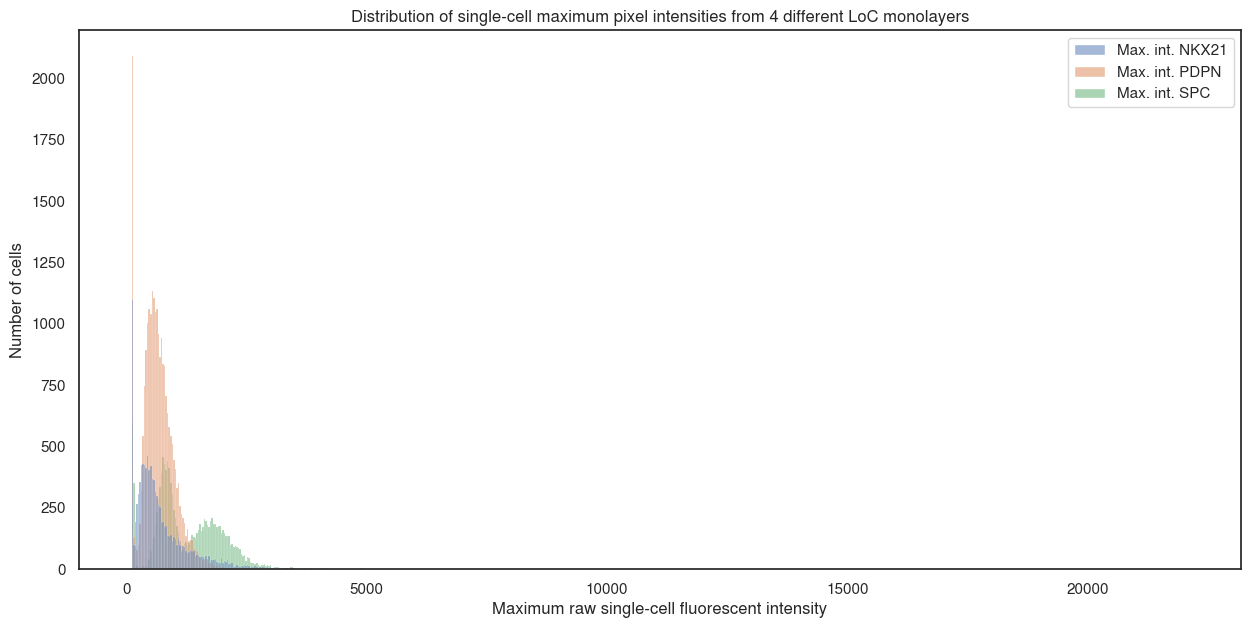

In [23]:
sns.histplot((dfs['Max. int. NKX21'], dfs['Max. int. PDPN'], dfs['Max. int. SPC']))
plt.title('Distribution of single-cell maximum pixel intensities from 4 different LoC monolayers')
# plt.xlim(0,3500)
plt.ylabel('Number of cells')
plt.xlabel('Maximum raw single-cell fluorescent intensity')
# plt.savefig('/home/dayn/data/lung_on_chip/single_cell_px_int/3_ch_sc_px_int.jpg', bbox_inches = 'tight', dpi = 314)

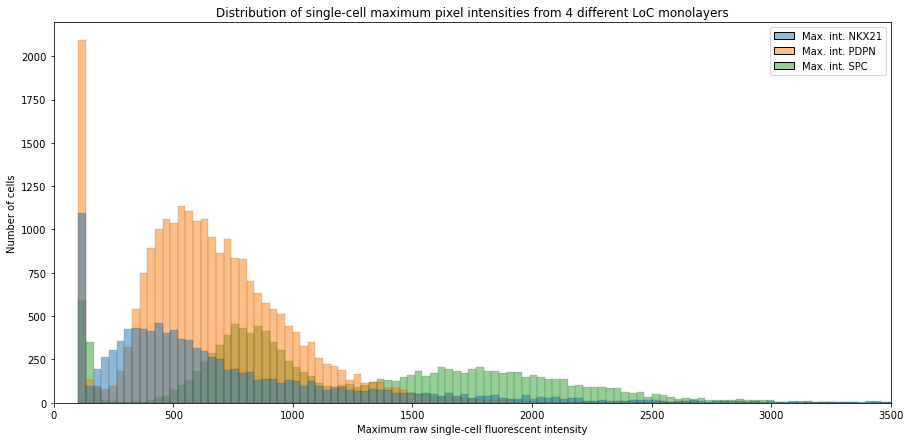

In [195]:
sns.histplot((dfs['Max. int. NKX21'], dfs['Max. int. PDPN'], dfs['Max. int. SPC']))
plt.title('Distribution of single-cell maximum pixel intensities from 4 different LoC monolayers')
plt.xlim(0,3500)
plt.ylabel('Number of cells')
plt.xlabel('Maximum raw single-cell fluorescent intensity')
plt.savefig('/home/dayn/data/lung_on_chip/single_cell_px_int/3_ch_sc_px_int_cropped.jpg', bbox_inches = 'tight', dpi = 314)

Text(0.5, 0, 'Maximum normalised single-cell fluorescent intensity')

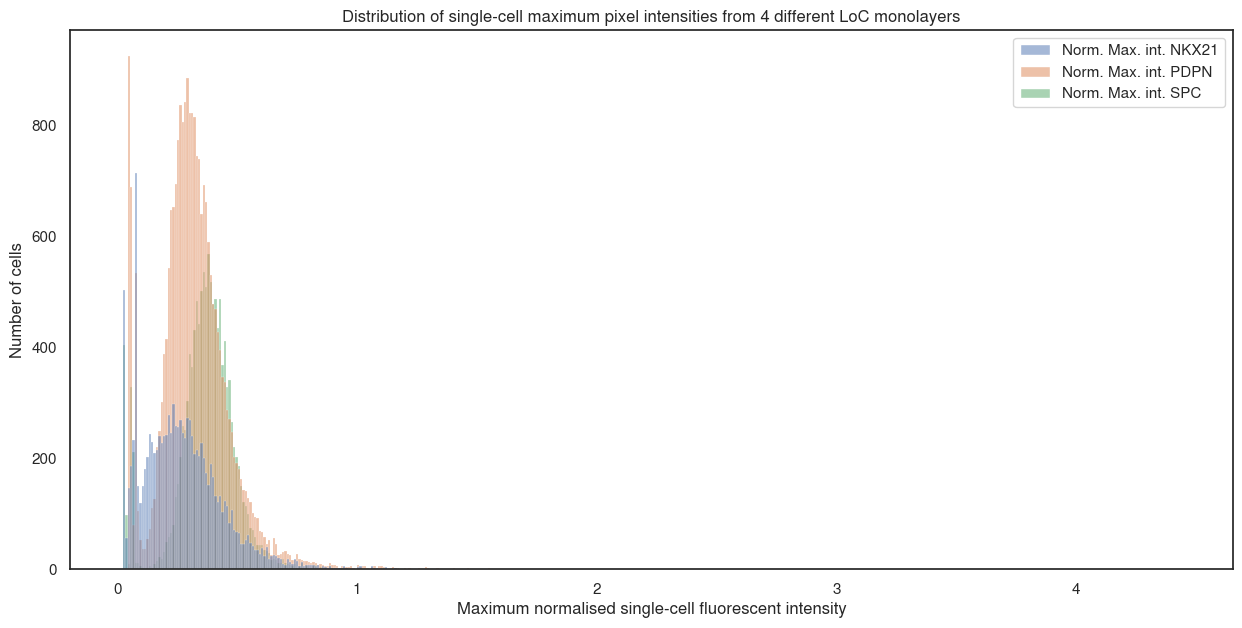

In [24]:
sns.histplot((dfs['Norm. Max. int. NKX21'], dfs['Norm. Max. int. PDPN'], dfs['Norm. Max. int. SPC']))
plt.title('Distribution of single-cell maximum pixel intensities from 4 different LoC monolayers')
# plt.xlim(0,3500)
plt.ylabel('Number of cells')
plt.xlabel('Maximum normalised single-cell fluorescent intensity')
# plt.savefig('/home/dayn/data/lung_on_chip/single_cell_px_int/3_ch_sc_px_int_norm.jpg', bbox_inches = 'tight', dpi = 314)

In [25]:
sns.histplot((dfs['Norm. Max. int. NKX21'], dfs['Norm. Max. int. PDPN'], dfs['Norm. Max. int. SPC']))
plt.title('Distribution of single-cell maximum pixel intensities from 4 different LoC monolayers')
plt.xlim(0,1)
plt.ylabel('Number of cells')
plt.xlabel('Maximum normalised single-cell fluorescent intensity')
# plt.savefig('/home/dayn/data/lung_on_chip/single_cell_px_int/3_ch_sc_px_int_norm_cropped.jpg', bbox_inches = 'tight', dpi = 314)

Text(0.5, 0, 'Maximum normalised single-cell fluorescent intensity')

In [200]:
for channel in ['SPC', 'NKX21', 'PDPN']:
    sns.histplot((dfs[f'Max. int. {channel}']))
    plt.title(f'Distribution of single-cell maximum {channel} pixel intensities from 4 different LoC monolayers')
    # plt.xlim(0,3500)
    plt.ylabel('Number of cells')
    plt.xlabel(f'Maximum raw single-cell {channel} fluorescent intensity')
    plt.savefig(f'/home/dayn/data/lung_on_chip/single_cell_px_int/{channel}_sc_px_int.jpg', bbox_inches = 'tight', dpi = 314)
    plt.clf()
    ### next fig
    sns.histplot((dfs[f'Max. int. {channel}']))
    plt.title(f'Distribution of single-cell maximum {channel} pixel intensities from 4 different LoC monolayers')
    plt.xlim(0,3500)
    plt.ylabel('Number of cells')
    plt.xlabel(f'Maximum raw single-cell {channel} fluorescent intensity')
    plt.savefig(f'/home/dayn/data/lung_on_chip/single_cell_px_int/{channel}_sc_px_int_cropped.jpg', bbox_inches = 'tight', dpi = 314)
    plt.clf()
    ### next fig
    sns.histplot((dfs[f'Norm. Max. int. {channel}']))
    plt.title(f'Distribution of single-cell maximum {channel} pixel intensities from 4 different LoC monolayers')
    plt.ylabel('Number of cells')
    plt.xlabel(f'Maximum normalised single-cell {channel} fluorescent intensity')
    plt.savefig(f'/home/dayn/data/lung_on_chip/single_cell_px_int/{channel}_sc_px_int_norm.jpg', bbox_inches = 'tight', dpi = 314)
    plt.clf()    
    ### next fig
    sns.histplot((dfs[f'Norm. Max. int. {channel}']))
    plt.title(f'Distribution of single-cell maximum {channel} pixel intensities from 4 different LoC monolayers')
    plt.xlim(0,1)
    plt.ylabel('Number of cells')
    plt.xlabel(f'Maximum normalised {channel} single-cell fluorescent intensity')
    plt.savefig(f'/home/dayn/data/lung_on_chip/single_cell_px_int/{channel}_sc_px_int_norm_cropped.jpg', bbox_inches = 'tight', dpi = 314)

###   Separating the experiment for PDPN


In [30]:
expt_IDS = set([ID for ID in dfs['Expt. ID']])

In [31]:
expt_IDS

{'/21-12-028A/236/',
 '/21-12-028A/245/',
 '/21-12-031B/113/',
 '/21-12-031B/122/'}

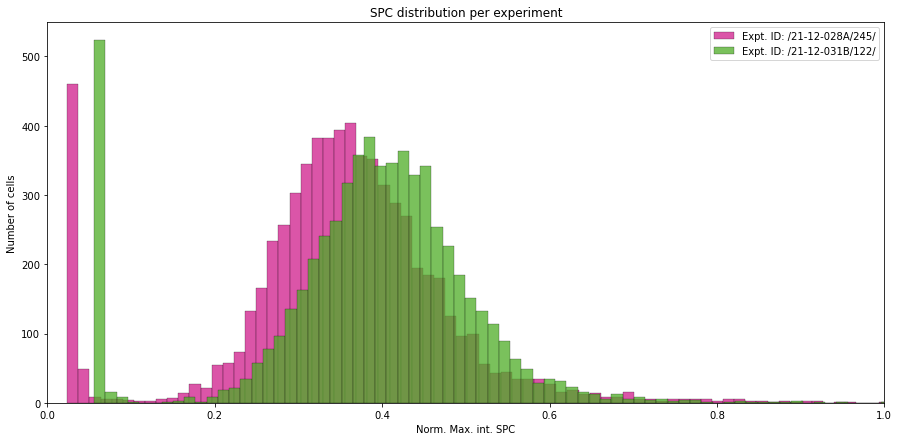

In [228]:
sns.histplot(dfs[dfs['Expt. ID'] == '/21-12-028A/245/']['Norm. Max. int. SPC'], color='#d01c8b', legend=True, label = 'Expt. ID: /21-12-028A/245/')
sns.histplot(dfs[dfs['Expt. ID'] == '/21-12-031B/122/']['Norm. Max. int. SPC'], color='#4dac26', legend= True, label = 'Expt. ID: /21-12-031B/122/')
plt.xlim(0,1)
plt.legend()
plt.ylabel('Number of cells')

plt.title('SPC distribution per experiment')
plt.savefig(f'/home/dayn/data/lung_on_chip/single_cell_px_int/SPC_per_expt_sc_px_int_norm_cropped.jpg', bbox_inches = 'tight', dpi = 314)


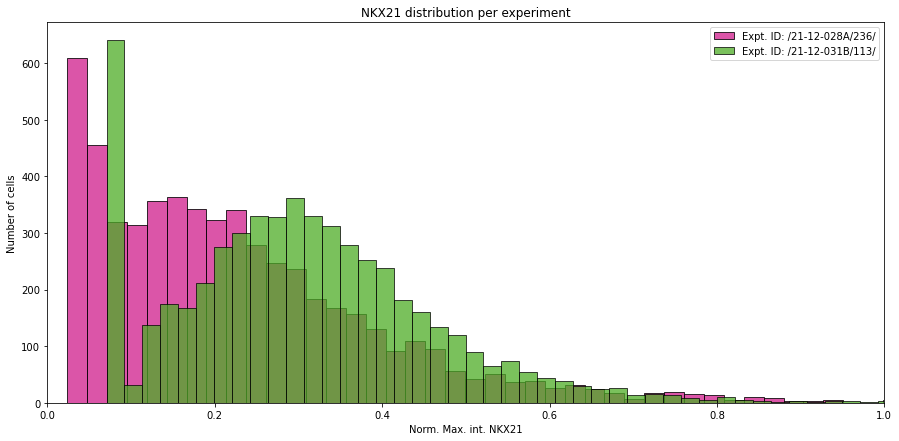

In [227]:
sns.histplot(dfs[dfs['Expt. ID'] == '/21-12-028A/236/']['Norm. Max. int. NKX21'], color='#d01c8b', legend=True, label = 'Expt. ID: /21-12-028A/236/')
sns.histplot(dfs[dfs['Expt. ID'] == '/21-12-031B/113/']['Norm. Max. int. NKX21'], color='#4dac26', legend= True, label = 'Expt. ID: /21-12-031B/113/')
plt.xlim(0,1)
plt.legend()
plt.ylabel('Number of cells')
plt.title('NKX21 distribution per experiment')
plt.savefig(f'/home/dayn/data/lung_on_chip/single_cell_px_int/NKX21_per_expt_sc_px_int_norm_cropped.jpg', bbox_inches = 'tight', dpi = 314)

In [229]:
sns.histplot(dfs[dfs['Expt. ID'] == '/21-12-028A/245/']['Norm. Max. int. PDPN'], color='#d01c8b', legend=True, label = 'Expt. ID: /21-12-028A/245/')
sns.histplot(dfs[dfs['Expt. ID'] == '/21-12-031B/122/']['Norm. Max. int. PDPN'], color='#f1b6da', legend= True, label = 'Expt. ID: /21-12-031B/122/')
sns.histplot(dfs[dfs['Expt. ID'] == '/21-12-028A/236/']['Norm. Max. int. PDPN'], color='#b8e186', legend=True, label = 'Expt. ID: /21-12-028A/236/')
sns.histplot(dfs[dfs['Expt. ID'] == '/21-12-031B/113/']['Norm. Max. int. PDPN'], color='#4dac26', legend= True, label = 'Expt. ID: /21-12-031B/113/')

plt.xlim(0,1)
plt.legend()
plt.ylabel('Number of cells')
plt.title('PDPN distribution per experiment')
plt.savefig(f'/home/dayn/data/lung_on_chip/single_cell_px_int/PDPN_per_expt_sc_px_int_norm_cropped.jpg', bbox_inches = 'tight', dpi = 314)

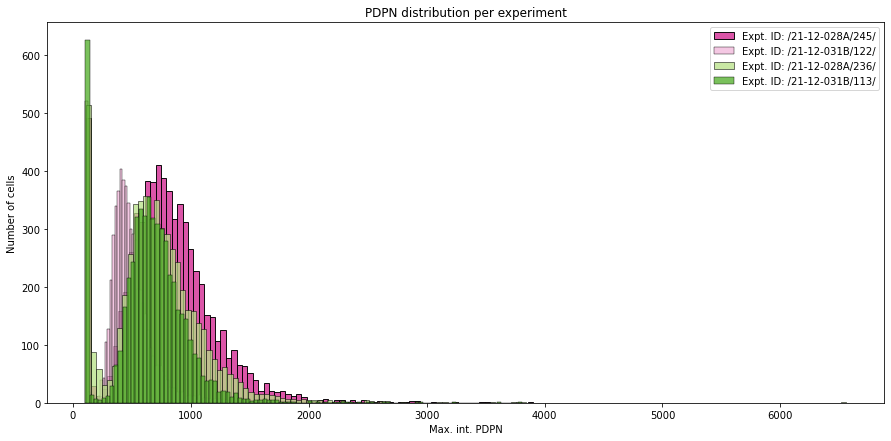

In [251]:
sns.histplot(dfs[dfs['Expt. ID'] == '/21-12-028A/245/']['Max. int. PDPN'], color='#d01c8b', legend=True, label = 'Expt. ID: /21-12-028A/245/')
sns.histplot(dfs[dfs['Expt. ID'] == '/21-12-031B/122/']['Max. int. PDPN'], color='#f1b6da', legend= True, label = 'Expt. ID: /21-12-031B/122/')
sns.histplot(dfs[dfs['Expt. ID'] == '/21-12-028A/236/']['Max. int. PDPN'], color='#b8e186', legend=True, label = 'Expt. ID: /21-12-028A/236/')
sns.histplot(dfs[dfs['Expt. ID'] == '/21-12-031B/113/']['Max. int. PDPN'], color='#4dac26', legend= True, label = 'Expt. ID: /21-12-031B/113/')

# plt.xlim(0,1)
plt.legend()
plt.ylabel('Number of cells')
plt.title('PDPN distribution per experiment')
plt.savefig(f'/home/dayn/data/lung_on_chip/single_cell_px_int/PDPN_per_expt_sc_px_int.jpg', bbox_inches = 'tight', dpi = 314)

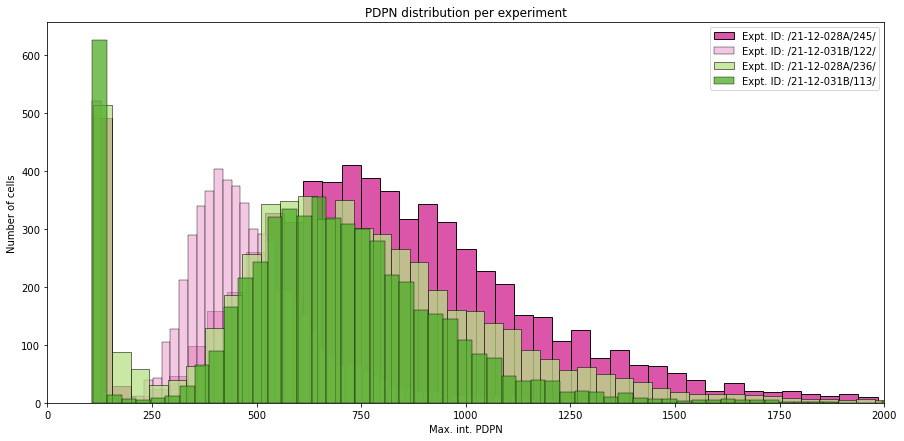

In [252]:
sns.histplot(dfs[dfs['Expt. ID'] == '/21-12-028A/245/']['Max. int. PDPN'], color='#d01c8b', legend=True, label = 'Expt. ID: /21-12-028A/245/')
sns.histplot(dfs[dfs['Expt. ID'] == '/21-12-031B/122/']['Max. int. PDPN'], color='#f1b6da', legend= True, label = 'Expt. ID: /21-12-031B/122/')
sns.histplot(dfs[dfs['Expt. ID'] == '/21-12-028A/236/']['Max. int. PDPN'], color='#b8e186', legend=True, label = 'Expt. ID: /21-12-028A/236/')
sns.histplot(dfs[dfs['Expt. ID'] == '/21-12-031B/113/']['Max. int. PDPN'], color='#4dac26', legend= True, label = 'Expt. ID: /21-12-031B/113/')

plt.xlim(0,2000)
plt.legend()
plt.ylabel('Number of cells')
plt.title('PDPN distribution per experiment')
plt.savefig(f'/home/dayn/data/lung_on_chip/single_cell_px_int/PDPN_per_expt_sc_px_int_cropped.jpg', bbox_inches = 'tight', dpi = 314)

# Applying threshold (from separate notebook)



In [27]:
spc_thresh = 750
pdpn_thresh = 800
nkx21_thresh = 300

thresh_dict = {'spc':750, 
              'pdpn':800, 
              'nkx21':300}

## Plotting threshold on plots

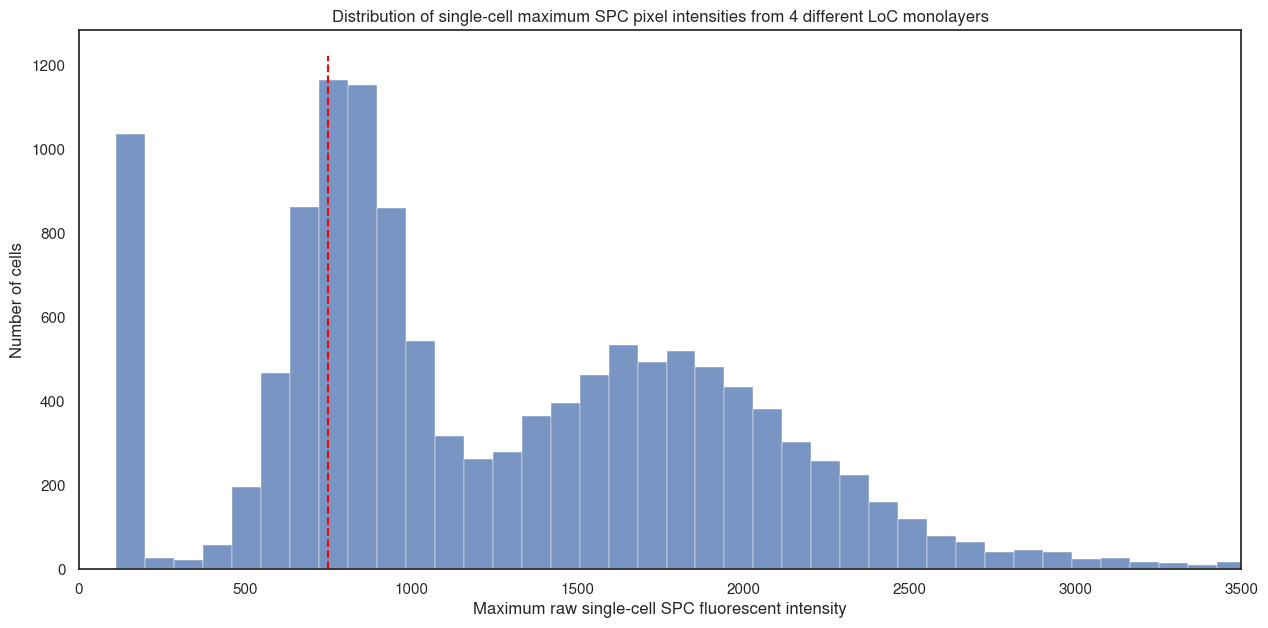

In [28]:
for channel in ['SPC', 'NKX21', 'PDPN']:
#     sns.histplot((dfs[f'Max. int. {channel}']))
#     plt.title(f'Distribution of single-cell maximum {channel} pixel intensities from 4 different LoC monolayers')
#     # plt.xlim(0,3500)
#     plt.ylabel('Number of cells')
#     plt.xlabel(f'Maximum raw single-cell {channel} fluorescent intensity')
#     plt.vlines(thresh_dict[f'{channel.lower()}'], plt.ylim()[0], plt.ylim()[1], colors='red', linestyles='dashed')
#     plt.savefig(f'/home/dayn/data/lung_on_chip/single_cell_px_int/{channel}_thresh_sc_px_int.jpg', bbox_inches = 'tight', dpi = 314)
#     plt.clf()
    ### next fig
    sns.histplot((dfs[f'Max. int. {channel}']))
    plt.title(f'Distribution of single-cell maximum {channel} pixel intensities from 4 different LoC monolayers')
    plt.xlim(0,3500)
    plt.ylabel('Number of cells')
    plt.vlines(thresh_dict[f'{channel.lower()}'], plt.ylim()[0], plt.ylim()[1], colors='red', linestyles='dashed')
    plt.xlabel(f'Maximum raw single-cell {channel} fluorescent intensity')
#     plt.savefig(f'/home/dayn/data/lung_on_chip/single_cell_px_int/{channel}_thresh_sc_px_int_cropped.jpg', bbox_inches = 'tight', dpi = 314)
#     plt.clf()
    break

In [32]:
expt_IDS

{'/21-12-028A/236/',
 '/21-12-028A/245/',
 '/21-12-031B/113/',
 '/21-12-031B/122/'}

In [33]:
df_113 = dfs[dfs['Expt. ID'] == '/21-12-031B/113/']

df_122 = dfs[dfs['Expt. ID'] == '/21-12-031B/122/']

df_236 = dfs[dfs['Expt. ID'] == '/21-12-028A/236/']

df_245 = dfs[dfs['Expt. ID'] == '/21-12-028A/245/']

In [37]:
import warnings
warnings.filterwarnings("ignore")


In [290]:
print('Number of positive vs. negative SPC cells in expt 245:', len(df_245[dfs['Max. int. SPC'] > spc_thresh]), ',', len(df_245[dfs['Max. int. SPC'] < spc_thresh]))

Number of positive vs. negative SPC cells in expt 245: 6153 , 546


In [35]:
print('Number of positive vs. negative SPC cells in expt 122:', len(df_122[dfs['Max. int. SPC'] > spc_thresh]), ',', len(df_122[dfs['Max. int. SPC'] < spc_thresh]))

Number of positive vs. negative SPC cells in expt 122: 3700 , 2444


/tmp/ipykernel_681427/3252028802.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print('Number of positive vs. negative SPC cells in expt 122:', len(df_122[dfs['Max. int. SPC'] > spc_thresh]), ',', len(df_122[dfs['Max. int. SPC'] < spc_thresh]))


In [36]:
print('Number of positive vs. negative NKX21 cells in expt 113:', len(df_113[dfs['Max. int. NKX21'] > nkx21_thresh]), ',', len(df_113[dfs['Max. int. NKX21'] < nkx21_thresh]))

Number of positive vs. negative NKX21 cells in expt 113: 4078 , 1433


/tmp/ipykernel_681427/1436370750.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print('Number of positive vs. negative NKX21 cells in expt 113:', len(df_113[dfs['Max. int. NKX21'] > nkx21_thresh]), ',', len(df_113[dfs['Max. int. NKX21'] < nkx21_thresh]))


In [38]:
print('Number of positive vs. negative NKX21 cells in expt 236:', len(df_236[dfs['Max. int. NKX21'] > nkx21_thresh]), ',', len(df_236[dfs['Max. int. NKX21'] < nkx21_thresh]))

Number of positive vs. negative NKX21 cells in expt 236: 4636 , 942


In [39]:
print('Number of positive vs. negative PDPN cells in expt 245:', len(df_245[dfs['Max. int. PDPN'] > pdpn_thresh]), ',', len(df_245[dfs['Max. int. PDPN'] < pdpn_thresh]))
print('Number of positive vs. negative PDPN cells in expt 122:', len(df_122[dfs['Max. int. PDPN'] > pdpn_thresh]), ',', len(df_122[dfs['Max. int. PDPN'] < pdpn_thresh]))
print('Number of positive vs. negative PDPN cells in expt 113:', len(df_113[dfs['Max. int. PDPN'] > pdpn_thresh]), ',', len(df_113[dfs['Max. int. PDPN'] < pdpn_thresh]))
print('Number of positive vs. negative PDPN cells in expt 236:', len(df_236[dfs['Max. int. PDPN'] > pdpn_thresh]), ',', len(df_236[dfs['Max. int. PDPN'] < pdpn_thresh]))

Number of positive vs. negative PDPN cells in expt 245: 3131 , 3568
Number of positive vs. negative PDPN cells in expt 122: 350 , 5795
Number of positive vs. negative PDPN cells in expt 113: 1523 , 3988
Number of positive vs. negative PDPN cells in expt 236: 2031 , 3547


In [296]:
df_245

Cell ID  Max. int. DAPI  Max. int. SPC  Max. int. PDPN  Max. int. ZO1  \
0          95      145.467102     123.779411      114.303032     102.643936   
1          96      163.291672     132.375000      129.500000     104.395836   
2          98      175.750000     141.916672      121.722221     105.320755   
3          99      199.744675     139.225800      121.384003     105.361702   
4          91      151.650787     133.030304      118.559998     102.682541   
...       ...             ...            ...             ...            ...   
6694    13118      181.651520     141.493149      124.727272     105.318184   
6695    13123      180.404755     154.173920      128.217392     109.826088   
6696    13072      189.975616     159.690216      130.829269     108.560974   
6697    13081      178.666672     145.000000      122.754097     105.245903   
6698    13094      141.112778     123.097748      111.450821     104.937500   

        Average X    Average Y   Mean Area  Max. Area  Min. Area  \
0      215.927629     5.392745  107.142857      304.0       33.0   
1      358.156282     4.258818   80.222222      185.0       24.0   
2      541.501545     4.414730   91.571429      218.0       36.0   
3      650.481270     4.308578  117.833333      163.0       47.0   
4      808.260254     3.822307   40.333333       63.0       25.0   
...           ...          ...         ...        ...        ...   
6694  2297.121094   655.070297   61.000000       94.0       11.0   
6695     6.599790   921.880730   55.666667      102.0       23.0   
6696     4.368395  1347.136932   83.000000      184.0       34.0   
6697  2296.673859  1365.022003   63.000000      165.0        3.0   
6698    26.302099  2294.222809  106.333333      133.0       64.0   

      Norm. Max. int. DAPI  Norm. Max. int. SPC  Norm. Max. int. PDPN  \
0                 0.015224             0.024830              0.045434   
1                 0.017090             0.026555              0.051474   
2                 0.018394             0.028469              0.048383   
3                 0.020905             0.027929              0.048248   
4                 0.015872             0.026686              0.047126   
...                    ...                  ...                   ...   
6694              0.019011             0.028384              0.049577   
6695              0.018881             0.030928              0.050964   
6696              0.019883             0.032034              0.052003   
6697              0.018699             0.029087              0.048793   
6698              0.014769             0.024694              0.044300   

      Norm. Max. int. ZO1          Expt. ID  Max. int. NKX21  \
0                0.226712  /21-12-028A/245/              NaN   
1                0.230582  /21-12-028A/245/              NaN   
2                0.232625  /21-12-028A/245/              NaN   
3                0.232715  /21-12-028A/245/              NaN   
4                0.226797  /21-12-028A/245/              NaN   
...                   ...               ...              ...   
6694             0.232619  /21-12-028A/245/              NaN   
6695             0.242576  /21-12-028A/245/              NaN   
6696             0.239781  /21-12-028A/245/              NaN   
6697             0.232459  /21-12-028A/245/              NaN   
6698             0.231778  /21-12-028A/245/              NaN   

      Norm. Max. int. NKX21  
0                       NaN  
1                       NaN  
2                       NaN  
3                       NaN  
4                       NaN  
...                     ...  
6694                    NaN  
6695                    NaN  
6696                    NaN  
6697                    NaN  
6698                    NaN  

[6699 rows x 17 columns]

In [40]:
expt_df_dict = {'df_245': df_245, 
               'df_122':df_122, 
               'df_113': df_113, 
               'df_236':df_236}

In [317]:
for i in expt_df_dict:
    print(i)

df_245
df_122
df_113
df_236


In [336]:
df

Cell ID  Max. int. DAPI  Max. int. SPC  Max. int. PDPN  Max. int. ZO1  \
6699       107      157.174759            NaN      118.351646     104.153847   
6700       100      159.750000            NaN      120.250000     104.271431   
6701       101      154.085709            NaN      117.238098     103.465279   
6702       103      146.048782            NaN      115.447762     103.987503   
6703       105      163.500000            NaN      122.851852     103.000000   
...        ...             ...            ...             ...            ...   
12272    15799      165.460312            NaN      115.428574     106.079369   
12273    15758      157.000000            NaN      125.571426     107.428574   
12274    15778      136.170212            NaN      114.361702     105.340424   
12275    15747      183.272720            NaN      119.025970     104.431816   
12276    15762      174.041168            NaN      121.779663     106.580002   

         Average X    Average Y   Mean Area  Max. Area  Min. Area  \
6699    387.210686     5.006570  115.666667      233.0       48.0   
6700    174.630783     7.153876   77.333333      251.0        8.0   
6701    198.845585     5.604357  141.714286      360.0       45.0   
6702    168.951102     3.815936   78.000000      147.0       36.0   
6703    307.594780     4.424199  100.000000      161.0       27.0   
...            ...          ...         ...        ...        ...   
12272   491.387566     5.630611   64.500000      109.0       30.0   
12273  2296.981079  1127.231384   42.200000       79.0        3.0   
12274  2298.694336  2294.278503  127.571429      257.0       47.0   
12275  2298.739105  1526.459854  101.000000      182.0       44.0   
12276     8.798428  1251.285812  155.600000      413.0       50.0   

       Norm. Max. int. DAPI  Norm. Max. int. SPC  Norm. Max. int. PDPN  \
6699               0.022072                  NaN              0.048479   
6700               0.022434                  NaN              0.049257   
6701               0.021638                  NaN              0.048023   
6702               0.020510                  NaN              0.047289   
6703               0.022960                  NaN              0.050322   
...                     ...                  ...                   ...   
12272              0.023236                  NaN              0.047282   
12273              0.022047                  NaN              0.051436   
12274              0.019122                  NaN              0.046845   
12275              0.025737                  NaN              0.048755   
12276              0.024441                  NaN              0.049883   

       Norm. Max. int. ZO1          Expt. ID  Max. int. NKX21  \
6699              0.194190  /21-12-028A/236/       114.312500   
6700              0.194410  /21-12-028A/236/       114.500000   
6701              0.192906  /21-12-028A/236/       117.284721   
6702              0.193880  /21-12-028A/236/       112.237503   
6703              0.192039  /21-12-028A/236/       116.812500   
...                    ...               ...              ...   
12272             0.197780  /21-12-028A/236/       117.566666   
12273             0.200296  /21-12-028A/236/       136.000000   
12274             0.196403  /21-12-028A/236/       115.456696   
12275             0.194709  /21-12-028A/236/       132.204544   
12276             0.198714  /21-12-028A/236/       124.000000   

       Norm. Max. int. NKX21  
6699                0.024900  
6700                0.024941  
6701                0.025548  
6702                0.024448  
6703                0.025445  
...                      ...  
12272               0.025609  
12273               0.029624  
12274               0.025150  
12275               0.028798  
12276               0.027010  

[5578 rows x 17 columns]

In [341]:
df[df[f'Max. int. {channel.name}']>100]

Cell ID  Max. int. DAPI  Max. int. SPC  Max. int. PDPN  Max. int. ZO1  \
6699       107      157.174759            NaN      118.351646     104.153847   
6700       100      159.750000            NaN      120.250000     104.271431   
6701       101      154.085709            NaN      117.238098     103.465279   
6702       103      146.048782            NaN      115.447762     103.987503   
6703       105      163.500000            NaN      122.851852     103.000000   
...        ...             ...            ...             ...            ...   
12272    15799      165.460312            NaN      115.428574     106.079369   
12273    15758      157.000000            NaN      125.571426     107.428574   
12274    15778      136.170212            NaN      114.361702     105.340424   
12275    15747      183.272720            NaN      119.025970     104.431816   
12276    15762      174.041168            NaN      121.779663     106.580002   

         Average X    Average Y   Mean Area  Max. Area  Min. Area  \
6699    387.210686     5.006570  115.666667      233.0       48.0   
6700    174.630783     7.153876   77.333333      251.0        8.0   
6701    198.845585     5.604357  141.714286      360.0       45.0   
6702    168.951102     3.815936   78.000000      147.0       36.0   
6703    307.594780     4.424199  100.000000      161.0       27.0   
...            ...          ...         ...        ...        ...   
12272   491.387566     5.630611   64.500000      109.0       30.0   
12273  2296.981079  1127.231384   42.200000       79.0        3.0   
12274  2298.694336  2294.278503  127.571429      257.0       47.0   
12275  2298.739105  1526.459854  101.000000      182.0       44.0   
12276     8.798428  1251.285812  155.600000      413.0       50.0   

       Norm. Max. int. DAPI  Norm. Max. int. SPC  Norm. Max. int. PDPN  \
6699               0.022072                  NaN              0.048479   
6700               0.022434                  NaN              0.049257   
6701               0.021638                  NaN              0.048023   
6702               0.020510                  NaN              0.047289   
6703               0.022960                  NaN              0.050322   
...                     ...                  ...                   ...   
12272              0.023236                  NaN              0.047282   
12273              0.022047                  NaN              0.051436   
12274              0.019122                  NaN              0.046845   
12275              0.025737                  NaN              0.048755   
12276              0.024441                  NaN              0.049883   

       Norm. Max. int. ZO1          Expt. ID  Max. int. NKX21  \
6699              0.194190  /21-12-028A/236/       114.312500   
6700              0.194410  /21-12-028A/236/       114.500000   
6701              0.192906  /21-12-028A/236/       117.284721   
6702              0.193880  /21-12-028A/236/       112.237503   
6703              0.192039  /21-12-028A/236/       116.812500   
...                    ...               ...              ...   
12272             0.197780  /21-12-028A/236/       117.566666   
12273             0.200296  /21-12-028A/236/       136.000000   
12274             0.196403  /21-12-028A/236/       115.456696   
12275             0.194709  /21-12-028A/236/       132.204544   
12276             0.198714  /21-12-028A/236/       124.000000   

       Norm. Max. int. NKX21  
6699                0.024900  
6700                0.024941  
6701                0.025548  
6702                0.024448  
6703                0.025445  
...                      ...  
12272               0.025609  
12273               0.029624  
12274               0.025150  
12275               0.028798  
12276               0.027010  

[5578 rows x 17 columns]

In [51]:
colors = sns.color_palette('PiYG')
colors

[(0.8129181084198386, 0.2544405997693195, 0.5693194925028835),
 (0.9348712033833141, 0.6798154555940021, 0.8312187620146096),
 (0.9856978085351787, 0.9031910803537101, 0.9458669742406767),
 (0.9202614379084968, 0.9629373317954633, 0.8576701268742792),
 (0.6908881199538641, 0.8624375240292197, 0.4883506343713959),
 (0.38269896193771624, 0.6403690888119954, 0.18108419838523643)]

In [57]:
# Modify the RGB values of the magenta color
magenta = (colors[0][0], colors[0][1], 0.8)  # Set blue component to 0.8 (adjust as desired)

# Update the color palette with the modified magenta color
colors[11] = magenta

# # Use the modified color palette for plotting
# sns.histplot(data, color=colors)  # Example plot using the modified color palette


IndexError: list assignment index out of range

In [62]:
output_dir = '/mnt/DATA/lung_on_chip/single_cell_px_int/per_expt_dist_thresholds/jun23'

In [66]:
plt.rcParams["figure.figsize"] = (15,5)

for expt in expt_df_dict:
    # Get the DataFrame corresponding to the experiment
    df = expt_df_dict[expt]
    
    # Get the experiment ID
    expt_ID = df['Expt. ID'].iloc[0]
    
    # Set the appropriate channels based on the experiment
    if '113' in expt or '236' in expt:
        channels = Channels_1
    if '122' in expt or '245' in expt:
        channels = Channels_2
    
    # Iterate over the channels
    for channel in channels:
        # Skip DAPI and ZO1 channels
        if channel.name == 'DAPI' or channel.name == 'ZO1':
            continue
        
        # Get the threshold value for the channel
        thresh = thresh_dict[channel.name.lower()]
        
        # Calculate the number of positive and negative cells based on the threshold
        pos_neg = (
            len(df[df[f'Max. int. {channel.name}'] > thresh]),
            len(df[df[f'Max. int. {channel.name}'] < thresh])
        )
        
        # Calculate the percentage of positive cells
        percentage = "{:.2f}".format((pos_neg[0] / (pos_neg[0] + pos_neg[1])) * 100)
        
        # Create the string for positive and negative cell counts and percentage
        pos_neg_string = f'Positive cells: {pos_neg[0]},\nnegative cells: {pos_neg[1]} \n{percentage}% positive'
        
        # Plot the histogram of maximum pixel intensities for the channel
        sns.histplot((df[f'Max. int. {channel.name}']), 
                     color='#6575DE',#colors[0], 
                     label=f'{pos_neg_string}')
        plt.legend()
        
        # Replace '/' in the experiment ID to avoid saving issues
        expt_ID = expt_ID.replace('/', '-')
        
        # Set the plot title, axis labels, and threshold line
        plt.title(f'Distribution of single-cell maximum {channel.name} pixel intensities from experiment ID: {expt_ID}')
        plt.ylabel('Number of cells')
        plt.xlabel(f'Maximum raw single-cell {channel.name} fluorescent intensity')
        plt.vlines(thresh_dict[f'{channel.name.lower()}'], plt.ylim()[0], plt.ylim()[1], 
                   colors='black',#colors[-1], 
                   linestyles='-')
        
        #Uncomment the following lines to save the plot as an image file and clear the plot for the next iteration
        fns = [os.path.join(output_dir, f'{channel.name}_expt_{expt_ID}_thresh_sc_px_int.jpg'), 
               os.path.join(output_dir, f'{channel.name}_expt_{expt_ID}_thresh_sc_px_int.pdf')]
        for fn in fns:
            plt.savefig(fn, bbox_inches='tight', dpi=314)
            plt.clf()
        
        # Break out of the channel loop after the first iteration
#         break
    
    # Break out of the experiment loop after the first iteration
#     break


<Figure size 1500x500 with 0 Axes>

In [68]:
expt_IDS

{'/21-12-028A/236/',
 '/21-12-028A/245/',
 '/21-12-031B/113/',
 '/21-12-031B/122/'}

In [75]:
# manually getting sensible x bounds from uncropped plots
crop_dict = {'-21-12-028A-236-': 2250, '-21-12-028A-245-': 2250, '-21-12-031B-113-': 1750, '-21-12-031B-122-':1750}

In [76]:
plt.rcParams["figure.figsize"] = (15,5)

for expt in expt_df_dict:
    # Get the DataFrame corresponding to the experiment
    df = expt_df_dict[expt]
    
    # Get the experiment ID
    expt_ID = df['Expt. ID'].iloc[0]
    
    # Set the appropriate channels based on the experiment
    if '113' in expt or '236' in expt:
        channels = Channels_1
    if '122' in expt or '245' in expt:
        channels = Channels_2
    
    # Iterate over the channels
    for channel in channels:
        # Skip DAPI and ZO1 channels
        if channel.name == 'DAPI' or channel.name == 'ZO1':
            continue
        
        # Get the threshold value for the channel
        thresh = thresh_dict[channel.name.lower()]
        
        # Calculate the number of positive and negative cells based on the threshold
        pos_neg = (
            len(df[df[f'Max. int. {channel.name}'] > thresh]),
            len(df[df[f'Max. int. {channel.name}'] < thresh])
        )
        
        # Calculate the percentage of positive cells
        percentage = "{:.2f}".format((pos_neg[0] / (pos_neg[0] + pos_neg[1])) * 100)
        
        # Create the string for positive and negative cell counts and percentage
        pos_neg_string = f'Positive cells: {pos_neg[0]},\nnegative cells: {pos_neg[1]} \n{percentage}% positive'
        
        # Plot the histogram of maximum pixel intensities for the channel
        sns.histplot((df[f'Max. int. {channel.name}']), 
                     color='#6575DE',#colors[0], 
                     label=f'{pos_neg_string}')
        plt.legend()
        
        # Replace '/' in the experiment ID to avoid saving issues
        expt_ID = expt_ID.replace('/', '-')
        
        # Set the plot title, axis labels, and threshold line
        plt.title(f'Distribution of single-cell maximum {channel.name} pixel intensities from experiment ID: {expt_ID}')
        plt.ylabel('Number of cells')
        plt.xlabel(f'Maximum raw single-cell {channel.name} fluorescent intensity')
        plt.vlines(thresh_dict[f'{channel.name.lower()}'], plt.ylim()[0], plt.ylim()[1], 
                   colors='black',#colors[-1], 
                   linestyles='-')
        # Uncomment the following lines to create a cropped version of the plot and save it as an image file
        x_crop = crop_dict[expt_ID]
        plt.xlim(0, x_crop)
        fns = [os.path.join(output_dir, f'{channel.name}_expt_{expt_ID}_thresh_sc_px_int_cropped.jpg'), 
               os.path.join(output_dir, f'{channel.name}_expt_{expt_ID}_thresh_sc_px_int_cropped.pdf')]
        for fn in fns:
            plt.savefig(fn, bbox_inches='tight', dpi=314)
            plt.clf()
        
        # Break out of the channel loop after the first iteration
#         break
    
    # Break out of the experiment loop after the first iteration
#     break


<Figure size 1500x500 with 0 Axes>

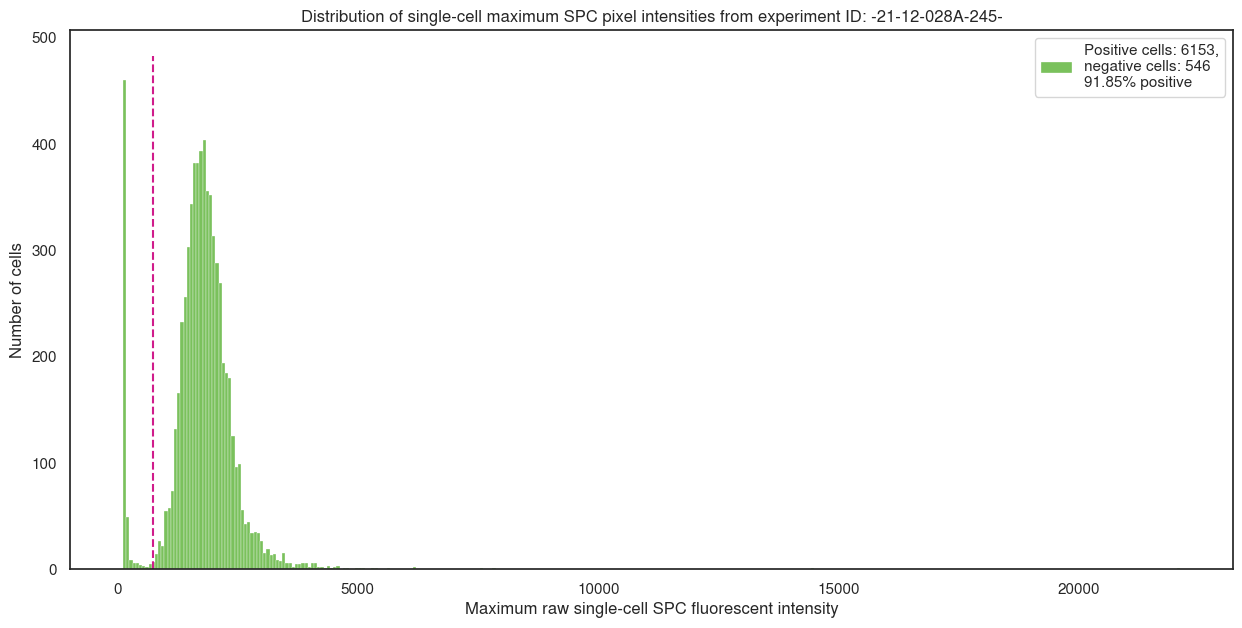

In [42]:
for expt in expt_df_dict:
    df = expt_df_dict[expt]    
    expt_ID = df['Expt. ID'].iloc[0]
    if '113' in expt or '236' in expt:
        channels = Channels_1
    if '122' in expt or '245' in expt:
        channels = Channels_2
    for channel in channels:
        if channel.name == 'DAPI' or channel.name == 'ZO1':
            continue
        
        thresh = thresh_dict[channel.name.lower()]
        pos_neg = (len(df[df[f'Max. int. {channel.name}'] > thresh]), len(df[df[f'Max. int. {channel.name}'] < thresh]))
        percentage = "{:.2f}".format((pos_neg[0]/(pos_neg[0]+pos_neg[1]))*100)
        pos_neg_string = f'Positive cells: {pos_neg[0]},\nnegative cells: {pos_neg[1]} \n{percentage}% positive'
        
        sns.histplot((df[f'Max. int. {channel.name}']), color='#4dac26', label = f'{pos_neg_string}')
        plt.legend()
        expt_ID = expt_ID.replace('/','-')
        plt.title(f'Distribution of single-cell maximum {channel.name} pixel intensities from experiment ID: {expt_ID}')
        plt.ylabel('Number of cells')
        plt.xlabel(f'Maximum raw single-cell {channel.name} fluorescent intensity')
        plt.vlines(thresh_dict[f'{channel.name.lower()}'], plt.ylim()[0], plt.ylim()[1], colors='#d01c8b', linestyles='dashed')
        plt.text
#         plt.savefig(f'/home/dayn/data/lung_on_chip/single_cell_px_int/{channel.name}_expt_{expt_ID}_thresh_sc_px_int.jpg', bbox_inches = 'tight', dpi = 314)
#         plt.clf()
#         ### next fig
#         sns.histplot((df[f'Max. int. {channel.name}']), color='#4dac26', label = f'{pos_neg_string}')
#         plt.legend()
#         plt.title(f'Distribution of single-cell maximum {channel.name} pixel intensities from experiment ID: {expt_ID}')        
#         plt.xlim(0,3500)
#         plt.ylabel('Number of cells')
#         plt.vlines(thresh_dict[f'{channel.name.lower()}'], plt.ylim()[0], plt.ylim()[1], colors='#d01c8b', linestyles='dashed')
#         plt.xlabel(f'Maximum raw single-cell {channel.name} fluorescent intensity')
#         plt.savefig(f'/home/dayn/data/lung_on_chip/single_cell_px_int/{channel.name}_expt_{expt_ID}_thresh_sc_px_int_cropped.jpg', bbox_inches = 'tight', dpi = 314)
#         plt.clf()
        break
    break

# Previous plotting

In [102]:
output_dir = '/home/dayn/Documents/presentations/221101_LoC'

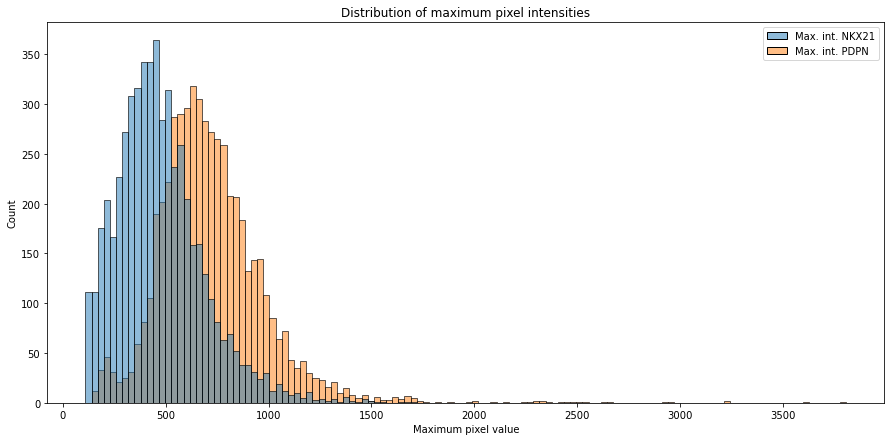

In [105]:
sns.histplot((df['Max. int. NKX21'], df['Max. int. PDPN']))
plt.title('Distribution of maximum pixel intensities')
plt.xlabel('Maximum pixel value')
plt.savefig(os.path.join(output_dir, 'max_int_dist.jpg'), dpi = 314, bbox_inches = 'tight')

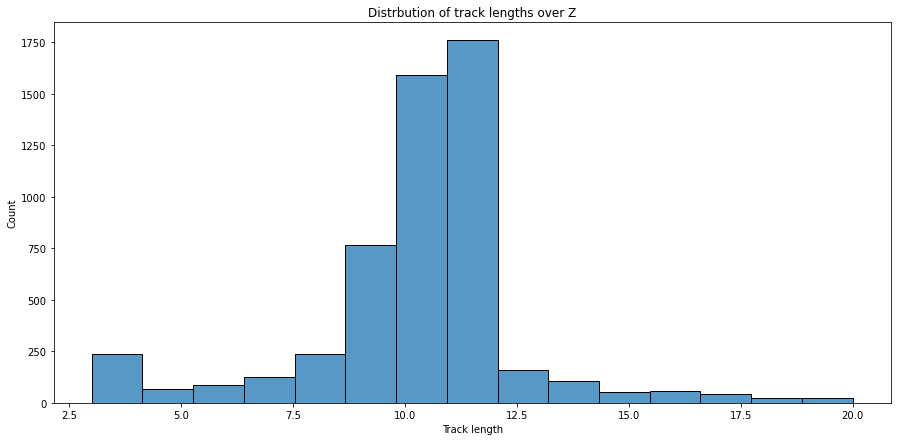

In [106]:
sns.histplot([len(track) for track in tracks], bins = 15)
plt.title('Distrbution of track lengths over Z')
plt.xlabel('Track length')
plt.savefig(os.path.join(output_dir, 'track_length_dist.jpg'), dpi = 314, bbox_inches = 'tight')

## Filtering track lengths

In [15]:
filtered_tracks = [track for track in tracks if len(track) > 7]

In [82]:
filtered_df = pd.DataFrame([(track.ID, np.nanmax(track['mean_intensity-0']),np.nanmax(track['mean_intensity-1']),np.nanmax(track['mean_intensity-2']),np.nanmax(track['mean_intensity-3']), np.mean(track.x), np.mean(track.y)) for track in filtered_tracks], columns= cols)
filtered_df

Cell ID  Max. int. DAPI  Max. int. NKX21  Max. int. PDPN  Max. int. ZO1  \
0         249      301.447835       176.244094      347.769470     135.199273   
1         260     1660.750000       819.633333      651.004104     134.643639   
2         259      675.338376       355.360777      493.353503     129.640127   
3         258     1150.301205       431.990361     1205.507837     133.434066   
4         257      412.382098       234.673347      439.279769     128.212425   
...       ...             ...              ...             ...            ...   
4808     8201     1467.596639       885.277311      652.621495     175.070093   
4809     8323      314.666667       171.900000     1099.533333     266.453333   
4810     8527     1265.281553       784.461165      849.706714     187.769231   
4811     8609      300.933798       170.275261      309.250871     209.336245   
4812     8571      575.269939       320.828221      981.000000     242.000000   

                x            y  
0      950.055128    11.320575  
1     1371.656425    15.771481  
2     2121.861659    12.777158  
3      238.755957     6.475418  
4      350.520471    15.824814  
...           ...          ...  
4808  1559.474781  1914.404537  
4809  2144.336086   264.639448  
4810  1571.751283  1902.370323  
4811  2088.909998   467.305009  
4812   396.818706   917.869222  

[4813 rows x 7 columns]

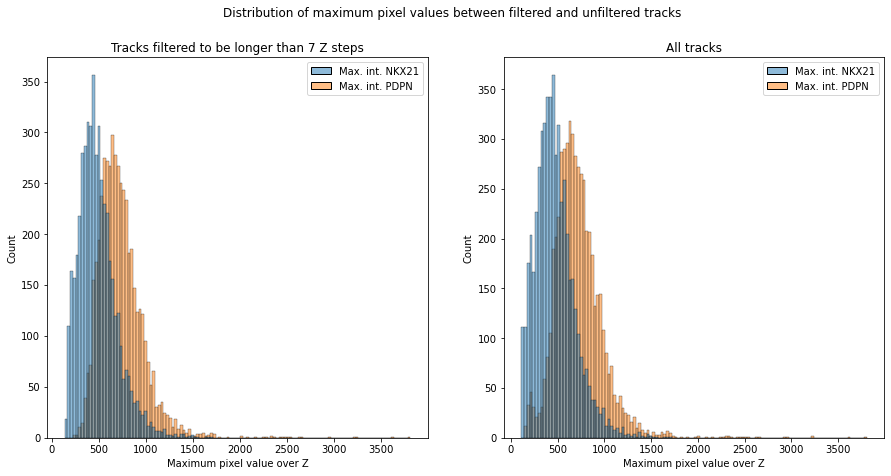

In [107]:
fig, ax =plt.subplots(1,2)
fig.suptitle('Distribution of maximum pixel values between filtered and unfiltered tracks')
sns.histplot((filtered_df['Max. int. NKX21'], filtered_df['Max. int. PDPN']), ax = ax[0])
ax[0].set_title('Tracks filtered to be longer than 7 Z steps')
ax[0].set(xlabel = 'Maximum pixel value over Z')
sns.histplot((df['Max. int. NKX21'], df['Max. int. PDPN']), ax = ax[1])
ax[1].set_title('All tracks')
ax[1].set(xlabel = 'Maximum pixel value over Z')
plt.savefig(os.path.join(output_dir, 'max_int_dist_filtered_comparison.jpg'), dpi = 314, bbox_inches = 'tight')

# Need to define a cut-off for a "positive" PDPN and NKX21 value

Generate glimpses and ask if a or b?

In [19]:
def make_glimpse(random_coords, image, mask_stack, size = 100):
    
    ### get coords of glimpse
    y, x, t = random_coords
    
    ### select frame of interest
    frame = image[t]
    ch1_frame = frame[...,1]
    ch2_frame = frame[...,2]
    ch3_frame = frame[...,3]
    mask_frame = mask_stack[t]

    ### obtain coordinates of bounding box of glimpse (centered on cell)
    x1, x2, y1, y2 = x, x+size, y, y+size #coordinates to crop by, shifted bearing in mind a further coord shift (+100,+100) occurs due to image padding            
    ### pad image incase cell goes off FOV
    ch1_frame = np.pad(ch1_frame, int(size/2), 'constant', constant_values = 0) 
    ch2_frame = np.pad(ch2_frame, int(size/2), 'constant', constant_values = 0) 
    ch3_frame = np.pad(ch3_frame, int(size/2), 'constant', constant_values = 0) 
    mask_frame = np.pad(mask_frame, int(size/2), 'constant', constant_values = 0) 
    ## glimpse creation by cropping original image
    ch1_glimpse = ch1_frame[int(x1): int(x2), int(y1): int(y2)]
    ch2_glimpse = ch2_frame[int(x1): int(x2), int(y1): int(y2)]
    ch3_glimpse = ch3_frame[int(x1): int(x2), int(y1): int(y2)]
    ### mask outline creation 
    mask_glimpse = mask_frame[int(x1): int(x2), int(y1): int(y2)]
    ### find pixel value of mask to extract single mask
    mask_pix_val = mask_glimpse[int(size/2),int(size/2)]
    mask_glimpse = (mask_glimpse ==mask_pix_val).astype(int)
    ### create outline
    mask_glimpse_erode = binary_erosion(mask_glimpse).astype(int)
    outline = np.logical_xor(mask_glimpse_erode, mask_glimpse)
    
    return ch1_glimpse, ch2_glimpse, ch3_glimpse, outline

In [21]:
import random
import warnings
warnings.filterwarnings("ignore")
from skimage.morphology import binary_erosion

In [ ]:
for track in (filtered_tracks):
    ## randomly select which channel to choose from 
    if random.randint(0,1) <1:
        print('Channel 1, KXC21')
        ### extracting index of maximum intensity value
        max_int = np.nanmax(track['mean_intensity-1'])
        index_max_value = np.where(track['mean_intensity-1'] == max_int)[0][0]
        ### extracting xyt coordinates of that cell at that time
        random_coords = (track.x[index_max_value], track.y[index_max_value], track.t[index_max_value])
        ### print selected glimpse info
        print(f"Track ID:{track.ID}, xyt:{random_coords}")
        ### make ch1 glimpse
        ch1_glimpse, _, ch3_glimpse, outline = make_glimpse(random_coords, image, mask_stack, size = 100)
        ### multiply the outline to both highlight it in the composite and fix the upper bound of the colormap
        outline = outline *1000
        ### launch a napari viewer to show glimpse
        viewer = napari.Viewer()
        viewer.add_image(ch1_glimpse, colormap = 'green', blending = 'additive', name = 'NKX21')
        viewer.add_image(ch3_glimpse, colormap = 'gray', blending = 'additive', name = 'ZO1')
        viewer.add_image(outline, colormap = 'magenta', blending = 'additive', name = 'Mask')
        ### wait until image is closed to enter pos or negative 
        viewer.show(block=True)
        ####
        print("Enter positive/negative as \"p\" or \"n\" for NKX21")
        ch1_val = input()
        ### record result
        if ch1_val == 'p':
            with open("NKCX21_positive.csv","a") as f:
                f.write(f"{max_int}\n")
        elif ch1_val == 'n':
            with open("NKCX21_negative.csv","a") as f:
                f.write(f"{max_int}\n")
        else:
            print('Did not recognise the positive/negative text input')
    ### now the other channel     
    else:
        print('Channel 2, PDPN')
        ### extracting index of maximum intensity value
        max_int = np.nanmax(track['mean_intensity-2'])
        index_max_value = np.where(track['mean_intensity-2'] == max_int)[0][0]
        ### extracting xyt coordinates of that cell at that time
        random_coords = (track.x[index_max_value], track.y[index_max_value], track.t[index_max_value])
        ### print selected glimpse info
        print(f"Track ID:{track.ID}, xyt:{random_coords}")
        ### make ch2 glimpse
        _, ch2_glimpse, ch3_glimpse, outline = make_glimpse(random_coords, image, mask_stack, size = 100)
        ### multiply the outline to both highlight it in the composite and fix the upper bound of the colormap
        outline = outline *1000
        ### launch a napari viewer to show glimpse
        viewer = napari.Viewer()
        viewer.add_image(ch2_glimpse, colormap = 'red', blending = 'additive', name = 'PDPN')
        viewer.add_image(ch3_glimpse, colormap = 'gray', blending = 'additive', name = 'ZO1')
        viewer.add_image(outline, colormap = 'magenta', blending = 'additive', name = 'Mask')
        ### wait until image is closed to enter pos or negative 
        viewer.show(block=True)
        ####
        print("Enter positive/negative as \"p\" or \"n\" for PDPN")
        ch1_val = input()
        ### record result
        if ch1_val == 'p':
            with open("PDPN_positive.csv","a") as f:
                f.write(f"{max_int}\n")
        elif ch1_val == 'n':
            with open("PDPN_negative.csv","a") as f:
                f.write(f"{max_int}\n")
        else:
            print('Did not recognise the positive/negative text input')

Channel 2, PDPN
Track ID:249, xyt:(953.5856697819314, 13.577881619937695, 8)
Enter positive/negative as "p" or "n" for PDPN
n
Channel 2, PDPN
Track ID:260, xyt:(1371.6518467852256, 15.842681258549932, 9)


Enter positive/negative as "p" or "n" for PDPN
n
Channel 2, PDPN
Track ID:259, xyt:(2120.6568471337578, 17.035828025477706, 10)


Enter positive/negative as "p" or "n" for PDPN
n
Channel 2, PDPN
Track ID:258, xyt:(238.95611285266457, 6.29153605015674, 7)


Enter positive/negative as "p" or "n" for PDPN
n
Channel 2, PDPN
Track ID:257, xyt:(349.8994643592913, 22.450762257931604, 7)


Enter positive/negative as "p" or "n" for PDPN
n
Channel 1, KXC21
Track ID:256, xyt:(477.56996587030716, 9.496018202502844, 7)


Enter positive/negative as "p" or "n" for NKX21
n
Channel 2, PDPN
Track ID:255, xyt:(521.0646706586826, 32.22694610778443, 8)


Enter positive/negative as "p" or "n" for PDPN
n
Channel 2, PDPN
Track ID:254, xyt:(522.7280701754386, 4.337719298245614, 8)


Enter positive/negative as "p" or "n" for PDPN
n
Channel 2, PDPN
Track ID:252, xyt:(576.5497175141243, 15.792090395480226, 8)


Enter positive/negative as "p" or "n" for PDPN
n
Channel 2, PDPN
Track ID:251, xyt:(1777.4908647990255, 17.24969549330085, 8)


Enter positive/negative as "p" or "n" for PDPN
n
Channel 2, PDPN
Track ID:250, xyt:(877.770731707317, 5.678048780487805, 9)


Enter positive/negative as "p" or "n" for PDPN
n
Channel 2, PDPN
Track ID:261, xyt:(675.4297872340426, 21.072340425531916, 8)


Enter positive/negative as "p" or "n" for PDPN
n
Channel 1, KXC21
Track ID:248, xyt:(1000.0732240437159, 14.71584699453552, 9)


Enter positive/negative as "p" or "n" for NKX21
